In [1]:
import sys
import numpy as np
import isambard_dev as isambard
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from setup_db import Json, Pdb, SuperHelix_Parameters, Conformation, BUDE_Energies \
,RosettaMP_Energies, Interhelix_Interactions, HOLE_Output, SASA_Estimates, Base

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
dbfile = 'refined1.db' # DB file
engine = create_engine('sqlite:///'+dbfile)
Base.metadata.bind = engine
DBSession = sessionmaker()
DBSession.bind = engine
session = DBSession()

In [3]:
models = session.query(Pdb).all()
sequence = list(models[0].sequence)

Extract all superhelical parameters for all models from DB

In [4]:
allmodels_shp = session.query(SuperHelix_Parameters).all()
allmodels_rad = [m.ca_radii for m in allmodels_shp]
allmodels_z = [m.axial_positions for m in allmodels_shp]
allmodels_azim = [m.azimuthal_angles for m in allmodels_shp]

<IPython.core.display.Javascript object>


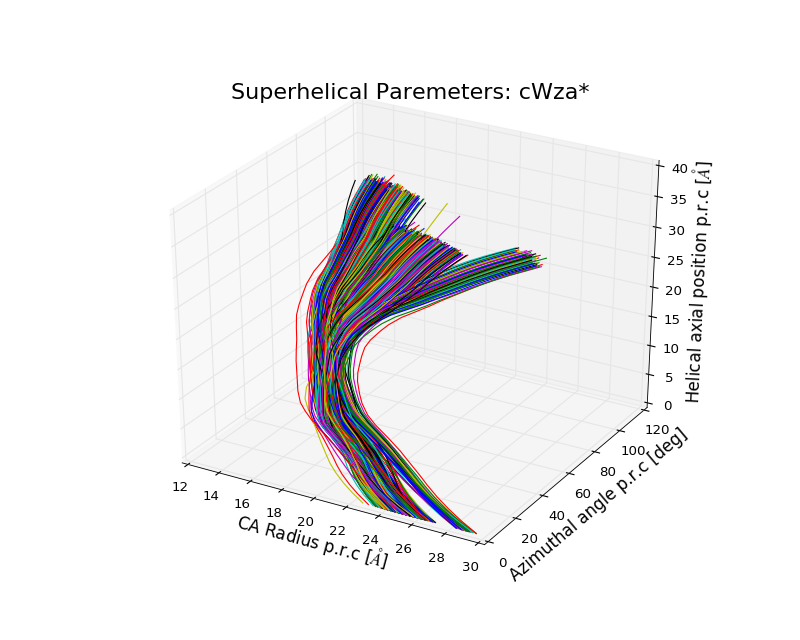

In [5]:
# Define figure size and type
fig0 = plt.figure(figsize=(10,8), dpi=80)
ax0 = fig0.add_subplot(111,projection='3d')

# Customize plot appereance
ax0.set_title('Superhelical Paremeters: cWza*',fontsize=20)
ax0.set_xlabel("CA Radius p.r.c [$\AA$]",fontsize=15)
ax0.set_ylabel("Azimuthal angle p.r.c [deg]",fontsize=15)
ax0.set_zlabel("Helical axial position p.r.c [$\AA$]",fontsize=15)

# Plot all curves in superhelical-parameter space per structure 
for i in range(len(allmodels_z)):
    x = np.array([v[1] for v in allmodels_rad[i]])
    y = np.array([v[1] for v in allmodels_azim[i]])
    z = np.array(allmodels_z[i])
    ax0.plot(x,y,z)

plt.show()

Plot interface angle values per residue in sequence

In [6]:
allmodels_iangles = [m.interface_angles for m in allmodels_shp]

<IPython.core.display.Javascript object>


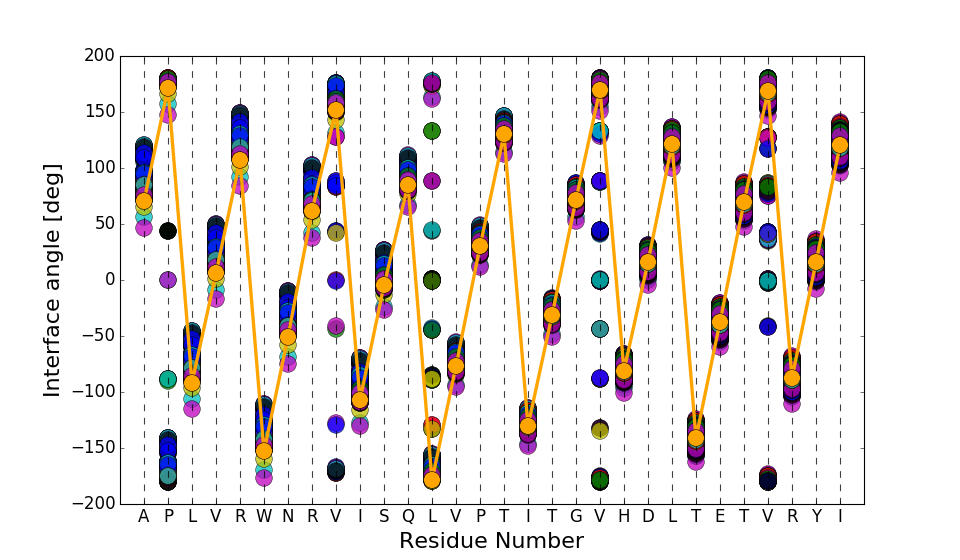

In [7]:
# Define figure size and type
fig1 = plt.figure(figsize=(12,7))

# Customize plot appereance
plt.xlim(0,31)
plt.xlabel("Residue Number",fontsize=20)
plt.xticks(range(1,31),sequence,fontsize=15)
plt.ylim(-200,200)
plt.ylabel("Interface angle [deg]",fontsize=20)
plt.yticks(fontsize=15)

# Plot interface angle values per structure
for i in range(1,len(allmodels_iangles)):
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.75)
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')

# Draw vertical dashed lines
for i in range(1,31):
    plt.plot((i,i),(-200,200),linestyle='--',color='black',alpha=0.75)

# Draw line connecting data points for first model, brought to the front
a = [v[1] for v in allmodels_iangles[0]]
plt.plot(range(1,len(a[:-2])+1),a[:-2],zorder=1000,marker='o',markersize=15,linewidth=3,color='orange')

plt.show()

Classify data in superhelical-parameter space using Spectral Clustering 

1) Define vectors in the 3N-dimensional parameter, where N refers to the number of residues in the protein sequence

In [8]:
X_test = []
for i in range(len(allmodels_z)):
    #x = np.linspace(1,32,32)
    x = [v[1] for v in allmodels_rad[i]]
    y = [v[1] for v in allmodels_azim[i]]
    z = allmodels_z[i]
    X_test.append(x+y+z)

In [9]:
X_test = np.asarray(X_test,dtype=np.float32)

2) Apply Spectral Clustering to high-dimensional data

In [10]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=3, affinity='nearest_neighbors',assign_labels='kmeans')
labels = model.fit_predict(X_test)

/home/ba13026/anaconda3/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:217: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


<IPython.core.display.Javascript object>


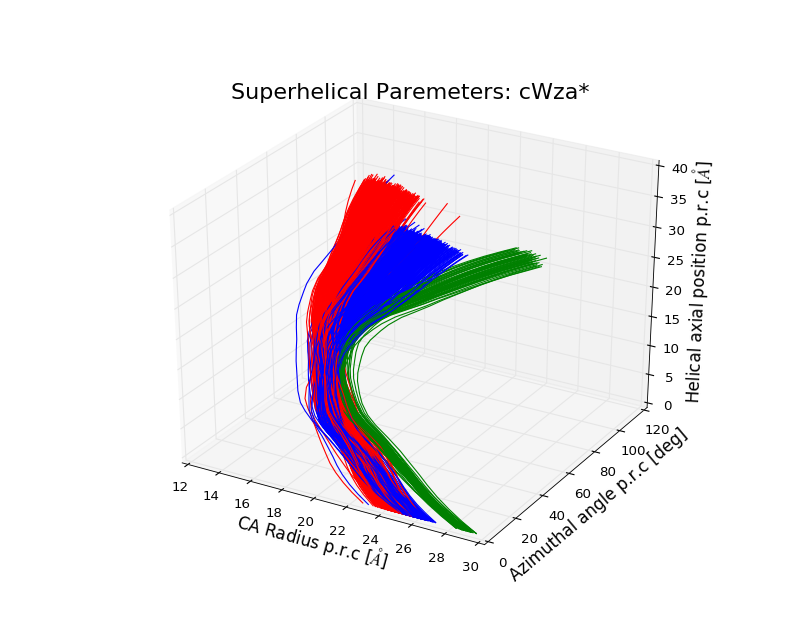

In [11]:
# Define discrete colour map for each classified group
from matplotlib import colors
cmap = colors.ListedColormap(['blue', 'green','red'])

fig2 = plt.figure(figsize=(10,8), dpi=80)
ax2 = fig2.add_subplot(111,projection='3d')

# Customize plot appereance
ax2.set_title('Superhelical Paremeters: cWza*',fontsize=20)
ax2.set_xlabel("CA Radius p.r.c [$\AA$]",fontsize=15)
ax2.set_ylabel("Azimuthal angle p.r.c [deg]",fontsize=15)
ax2.set_zlabel("Helical axial position p.r.c [$\AA$]",fontsize=15)

# Plot curves coloured by classified group
for i in range(len(allmodels_z)):
    x = [v[1] for v in allmodels_rad[i]]
    y = [v[1] for v in allmodels_azim[i]]
    z = allmodels_z[i]
    ax2.plot(x,y,z,color=cmap(labels[i]))

plt.show()

<IPython.core.display.Javascript object>


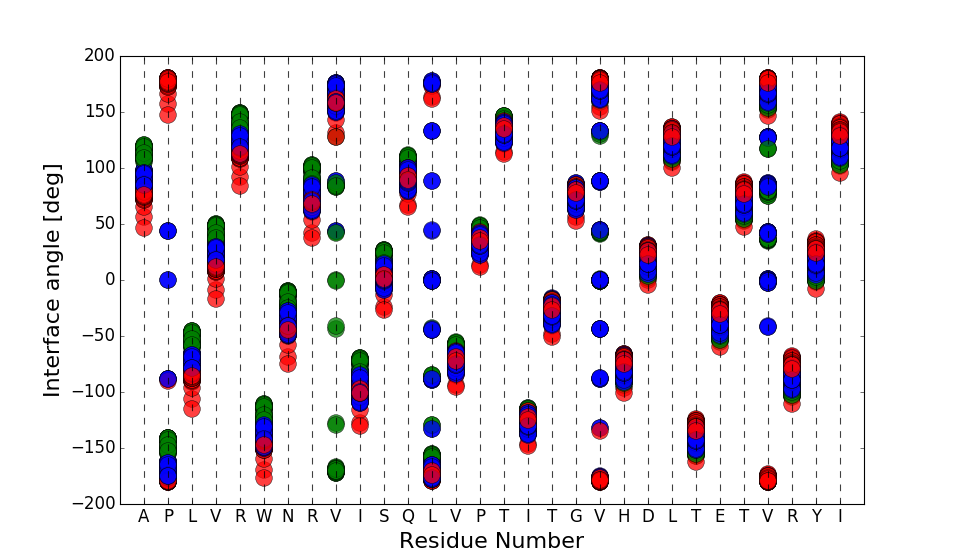

In [12]:
# Define figure size and type
fig1 = plt.figure(figsize=(12,7))

# Customize plot appereance
plt.xlim(0,31)
plt.xlabel("Residue Number",fontsize=20)
plt.xticks(range(1,31),sequence,fontsize=15)
plt.ylim(-200,200)
plt.ylabel("Interface angle [deg]",fontsize=20)
plt.yticks(fontsize=15)

# Plot interface angle values per structure
for i in range(1,len(allmodels_iangles)):
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.75,color=cmap(labels[i]) )
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')

# Draw vertical dashed lines
for i in range(1,31):
    plt.plot((i,i),(-200,200),linestyle='--',color='black',alpha=0.75)

# Draw line connecting data points for first model, brought to the front
#a = [v[1] for v in allmodels_iangles[0]]
#plt.plot(range(1,len(a[:-2])+1),a[:-2],zorder=1000,marker='o',markersize=15,linewidth=3,color='orange')
#plt.plot(range(1,len(a[:-2])+1),a[:-2],zorder=1000,marker='o',markersize=15,linestyle="None",color='orange',alpha=0.75)    

plt.show()

Get all pdb identities from classified models

In [ ]:
allpdbnames = [m.pdb_name for m in models]
group0 = np.asarray(allpdbnames)[np.asarray(labels) == 0]
group1 = np.asarray(allpdbnames)[np.asarray(labels) == 1]
group2 = np.asarray(allpdbnames)[np.asarray(labels) == 2]

In [ ]:
print(len(group0),len(group1),len(group2))

## Looking at the energy from each group

In [13]:
def weights4hist(data):
    return np.ones_like(data)/float(len(data))

<IPython.core.display.Javascript object>


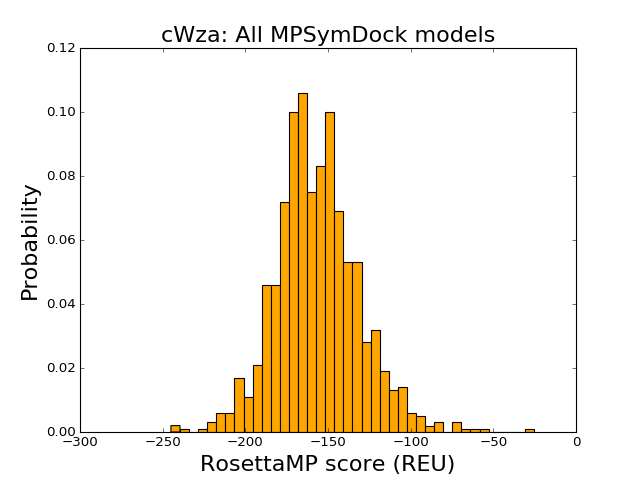

In [14]:
allmodels_Isc = session.query(RosettaMP_Energies.I_sc).all()
Isc_all = list([v[0] for v in allmodels_Isc])

fig5 = plt.figure()
# Customize plot
plt.title("cWza: All MPSymDock models", fontsize=20)
plt.xlabel("RosettaMP score (REU)", fontsize=20)
plt.xlim(-300,0)
plt.ylabel("Probability", fontsize=20)
plt.ylim(0,0.12)

plt.hist(Isc_all, bins=40,color='orange',weights=weights4hist(Isc_all))
plt.show()

In [ ]:
Isc_group0 = np.asarray(Isc_all)[np.asarray(labels) == 0]
Isc_group1 = np.asarray(Isc_all)[np.asarray(labels) == 1]
Isc_group2 = np.asarray(Isc_all)[np.asarray(labels) == 2]

# Verify data correctly separated
print(len(Isc_group0), len(Isc_group1), len(Isc_group2))

fig6 = plt.figure()
# Customize plot
plt.title("cWza: MPSymDock models, group separation", fontsize=20)
plt.xlabel("RosettaMP score (REU)", fontsize=20)
plt.xlim(-300,0)
plt.ylabel("Probability", fontsize=20)
#plt.ylim(0,0.12)

#plt.hist(Isc_all, bins=40,color='y',weights=weights4hist(Isc_all))
plt.hist(Isc_group0, bins=40,color=cmap(0),weights=weights4hist(Isc_group0),alpha=0.5)
plt.hist(Isc_group1, bins=40,color=cmap(1),weights=weights4hist(Isc_group1),alpha=0.5)
#plt.hist(Isc_group2, bins=20,color='r',weights=weights4hist(Isc_group2),alpha=0.5)

plt.show()

In [ ]:
fig7 = plt.figure()
# Customize plot
plt.title("cWza: MPSymDock models, group separation", fontsize=20)
plt.xlabel("RosettaMP score (REU)", fontsize=20)
plt.xlim(-300,0)
plt.ylabel("Probability", fontsize=20)

plt.hist(Isc_group2, bins=10,color=cmap(2),weights=weights4hist(Isc_group2),alpha=0.5)

plt.show()

Work out mean and std values of energy for all groups and individual ones

In [ ]:
print("I_sc Global: ", np.mean(Isc_all), np.std(Isc_all))
print("I_sc Group0: ", np.mean(Isc_group0), np.std(Isc_group0))
print("I_sc Group1: ", np.mean(Isc_group1), np.std(Isc_group1))
print("I_sc Group2: ", np.mean(Isc_group2), np.std(Isc_group2))

### Energy funnel for all models

In [ ]:
rmsd_file = open('rmsd_refined1.dat', 'r')
rmsd_all = [float(v) for v in rmsd_file.readlines()]

In [ ]:
fig8 = plt.figure()

# Customize plot
plt.title("cWza: All MPSymDock models", fontsize=20)
plt.xlabel("RMSD [$\AA$]", fontsize=20)
plt.xlim(0,5)
plt.ylabel("Interfacial Score (REU)", fontsize=20)
plt.ylim(-300,0)

plt.scatter(rmsd_all,Isc_all,color='orange',c='orange')

plt.show()

In [ ]:
rmsd_group0 = np.asarray(rmsd_all)[np.asarray(labels) == 0]
rmsd_group1 = np.asarray(rmsd_all)[np.asarray(labels) == 1]
rmsd_group2 = np.asarray(rmsd_all)[np.asarray(labels) == 2]

# Verify data correctly separated
print(len(rmsd_group0), len(rmsd_group1), len(rmsd_group2))

fig9 = plt.figure()

# Customize plot
plt.title("cWza: MPSymDock models, group separation", fontsize=20)
plt.xlabel("RMSD [$\AA$]", fontsize=20)
plt.xlim(0,5)
plt.ylabel("Interfacial Score (REU)", fontsize=20)
plt.ylim(-300,0)

plt.scatter(rmsd_group0,Isc_group0,color='b',alpha=0.4)
plt.scatter(rmsd_group1,Isc_group1,color='g',s=40, alpha=0.4)
plt.scatter(rmsd_group2,Isc_group2,color='r')

plt.show()

### All atom RMSD results

By default Rosetta RMSD is done by backbone alignment 

In [ ]:
def run_profit(n):
    p0 = isambard_dev.ampal.convert_pdb_to_ampal('cwza_NoWPN_relabeled.pdb')
    p1 = isambard_dev.ampal.convert_pdb_to_ampal(pdbnames[n])
    data = {}
    rmsds = isambard_dev.external_programs.run_profit(p0.pdb, p1.pdb, path1=False, path2=False, path_to_cmd_file=None,
               return_pdb_string=False, align_type='all')
    data[str(pdbnames[n])] = rmsds
    return

In [ ]:
infile = open('pdblist_refined1.txt', 'r')
pdbnames = [ l.rstrip() for l in infile.readlines()]

import isambard_dev
p0 = isambard_dev.ampal.convert_pdb_to_ampal('cwza_NoWPN_relabeled.pdb')

aa_rmsd_native = []
aa_rmsd_sc_native = []
for pdb in pdbnames:
    p1 = isambard_dev.ampal.convert_pdb_to_ampal(pdb)
    rmsds = isambard_dev.external_programs.run_profit(p0.pdb, p1.pdb, path1=False, path2=False, path_to_cmd_file=None,
               return_pdb_string=False, align_type='all')
    aa_rmsd_native.append(rmsds[2])
    aa_rmsd_sc_native.append(rmsds[2]-rmsds[1])

In [ ]:
fig8_0 = plt.figure()

# Customize plot
plt.title("cWza: All MPSymDock models", fontsize=20)
plt.xlabel("RMSD [$\AA$]", fontsize=20)
plt.xlim(0,5)
plt.ylabel("Interfacial Score (REU)", fontsize=20)
plt.ylim(-300,0)

plt.scatter(aa_rmsd_native,Isc_all,color='orange',c='orange')

plt.show()

In [ ]:
fig8_1 = plt.figure()

# Customize plot
plt.title("cWza: All MPSymDock models", fontsize=20)
plt.xlabel("RMSD [$\AA$]", fontsize=20)
plt.xlim(0,5)
plt.ylabel("Interfacial Score (REU)", fontsize=20)
plt.ylim(-300,0)

plt.scatter(aa_rmsd_sc_native,Isc_all,color='orange',c='orange')

plt.show()

In [ ]:
rmsd_group0_profit = np.asarray(aa_rmsd_native)[np.asarray(labels) == 0]
rmsd_group1_profit = np.asarray(aa_rmsd_native)[np.asarray(labels) == 1]
rmsd_group2_profit = np.asarray(aa_rmsd_native)[np.asarray(labels) == 2]

# Verify data correctly separated
print(len(rmsd_group0_profit), len(rmsd_group1_profit), len(rmsd_group2_profit))

fig9_0 = plt.figure()

# Customize plot
plt.title("cWza: MPSymDock models, group separation", fontsize=20)
plt.xlabel("RMSD [$\AA$]", fontsize=20)
plt.xlim(0,5)
plt.ylabel("Interfacial Score (REU)", fontsize=20)
plt.ylim(-300,0)

plt.scatter(rmsd_group0_profit,Isc_group0,color='b',alpha=0.5)
plt.scatter(rmsd_group1_profit,Isc_group1,color='g',s=40, alpha=0.15)
plt.scatter(rmsd_group2_profit,Isc_group2,color='r')

plt.show()

In [ ]:
rmsdsc_group0_profit = np.asarray(aa_rmsd_sc_native)[np.asarray(labels) == 0]
rmsdsc_group1_profit = np.asarray(aa_rmsd_sc_native)[np.asarray(labels) == 1]
rmsdsc_group2_profit = np.asarray(aa_rmsd_sc_native)[np.asarray(labels) == 2]

# Verify data correctly separated
print(len(rmsdsc_group0_profit), len(rmsdsc_group1_profit), len(rmsdsc_group2_profit))

fig9_sc = plt.figure()

# Customize plot
plt.title("cWza: MPSymDock models, group separation", fontsize=20)
plt.xlabel("RMSD [$\AA$]", fontsize=20)
plt.xlim(0,5)
plt.ylabel("Interfacial Score (REU)", fontsize=20)
plt.ylim(-300,0)

plt.scatter(rmsdsc_group0_profit,Isc_group0,color='b',alpha=0.5)
plt.scatter(rmsdsc_group1_profit,Isc_group1,color='g',s=40, alpha=0.15)
plt.scatter(rmsdsc_group2_profit,Isc_group2,color='r')

plt.show()

Comparison wrt relaxed initial structure `refined1.pdb`

In [ ]:
infile = open('pdblist_refined1.txt', 'r')
pdbnames = [ l.rstrip() for l in infile.readlines()]

import isambard_dev
p0 = isambard_dev.ampal.convert_pdb_to_ampal('refined1_relabeled.pdb')

aa_rmsd_refined1 = []
for pdb in pdbnames:
    p1 = isambard_dev.ampal.convert_pdb_to_ampal(pdb)
    rmsds = isambard_dev.external_programs.run_profit(p0.pdb, p1.pdb, path1=False, path2=False, path_to_cmd_file=None,
               return_pdb_string=False, align_type='all')
    aa_rmsd_refined1.append(rmsds[2])

In [ ]:
fig8_1 = plt.figure()

# Customize plot
plt.title("cWza: All MPSymDock models", fontsize=20)
plt.xlabel("RMSD [$\AA$]", fontsize=20)
plt.xlim(0,5)
plt.ylabel("Interfacial Score (REU)", fontsize=20)
plt.ylim(-300,0)

plt.scatter(aa_rmsd_refined1,Isc_all,color='orange',c='orange')

plt.show()

In [ ]:
rmsd_group0_refined1 = np.asarray(aa_rmsd_refined1)[np.asarray(labels) == 0]
rmsd_group1_refined1 = np.asarray(aa_rmsd_refined1)[np.asarray(labels) == 1]
rmsd_group2_refined1 = np.asarray(aa_rmsd_refined1)[np.asarray(labels) == 2]

# Verify data correctly separated
print(len(rmsd_group0_refined1), len(rmsd_group1_refined1), len(rmsd_group2_refined1))

fig8_2 = plt.figure()

# Customize plot
plt.title("cWza: MPSymDock models, group separation", fontsize=20)
plt.xlabel("RMSD [$\AA$]", fontsize=20)
plt.xlim(0,5)
plt.ylabel("Interfacial Score (REU)", fontsize=20)
plt.ylim(-300,0)

plt.scatter(rmsd_group0_refined1,Isc_group0,color='b',alpha=0.5)
plt.scatter(rmsd_group1_refined1,Isc_group1,color='g',s=40, alpha=0.15)
plt.scatter(rmsd_group2_refined1,Isc_group2,color='r')

plt.show()

In [ ]:
fig9_0 = plt.figure()

# Customize plot
plt.title("cWza: MPSymDock models, group separation", fontsize=20)
plt.xlabel("RMSD [$\AA$]", fontsize=20)
plt.xlim(0,5)
plt.ylabel("Probability", fontsize=20)

plt.hist(rmsd_all,bins=30,color='orange',weights=weights4hist(rmsd_all),alpha=1)

plt.show()

In [ ]:
fig9_1 = plt.figure()

# Customize plot
plt.title("cWza: MPSymDock models, group separation", fontsize=20)
plt.xlabel("RMSD [$\AA$]", fontsize=20)
plt.xlim(0,5)
plt.ylabel("Probability", fontsize=20)

plt.hist(rmsd_group0,bins=30,color='b',weights=weights4hist(rmsd_group0),alpha=0.3)
plt.hist(rmsd_group1,bins=30,color='g',weights=weights4hist(rmsd_group1),alpha=0.5)

plt.show()

In [ ]:
fig9_2 = plt.figure()

# Customize plot
plt.title("cWza: MPSymDock models, group separation", fontsize=20)
plt.xlabel("RMSD [$\AA$]", fontsize=20)
plt.xlim(0,5)
plt.ylabel("Probability", fontsize=20)

plt.hist(rmsd_group2,bins=10,color='r',weights=weights4hist(rmsd_group2),alpha=0.5)

plt.show()

In [ ]:
print("RMSD Global: ", np.mean(rmsd_all), np.std(rmsd_all))
print("RMSD Group0: ", np.mean(rmsd_group0), np.std(rmsd_group0))
print("RMSD Group1: ", np.mean(rmsd_group1), np.std(rmsd_group1))
print("RMSD Group2: ", np.mean(rmsd_group2), np.std(rmsd_group2))

## HOLE conductance per group

Obtain all HOLE Gpred(Rmin) values for all MPSymDock structures

In [15]:

model_ids = []
for n in range(1,1001):
    mid = session.query(Pdb.id).filter_by(
        pdb_name='input/refined1_0001_INPUT_'+str(format(n,'04d'))+'_ignorechain.pdb' ).first()
    model_ids.append(mid[0])

Gpred_Rmin_all = []
for id in model_ids:
    try:
        model_Gpred_Rmin = session.query(HOLE_Output.Gpred_Rmin).filter_by(id = id).one()
        Gpred_Rmin_all.append(model_Gpred_Rmin[0])
    except:
        Gpred_Rmin_all.append(-1)


In [16]:
len(Gpred_Rmin_all)

1000

Plot histogram of conductance values for all structures

In [17]:
# Define bimodal distribution function
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

<IPython.core.display.Javascript object>


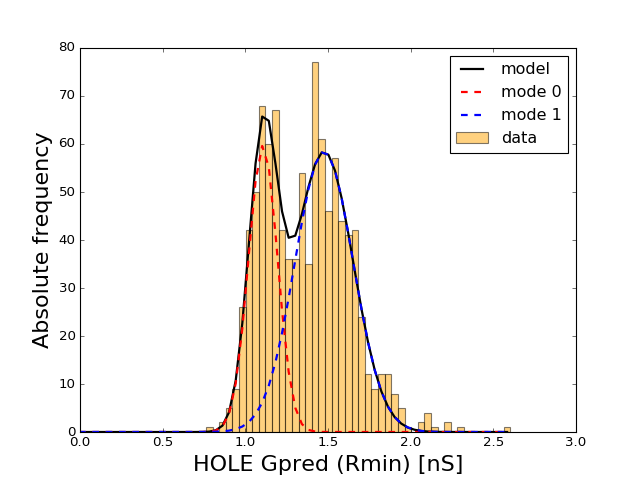

,params,sigma
mu1,1.107099,0.006002
sigma1,0.087745,0.005887
A1,59.698239,3.190409
mu2,1.476260,0.010105
sigma2,0.176261,0.010597
A2,58.413679,1.929068


In [18]:
from scipy.optimize import curve_fit
import pandas as pd

# Classify data by groups
#Gpred_Rmin_group0 = np.asarray(Gpred_Rmin_all)[np.asarray(labels) == 0]
#Gpred_Rmin_group1 = np.asarray(Gpred_Rmin_all)[np.asarray(labels) == 1]
#Gpred_Rmin_group2 = np.asarray(Gpred_Rmin_all)[np.asarray(labels) == 2]

Gpred_Rmin_all = [float(v) for v in Gpred_Rmin_all if v != 'None']
#Gpred_Rmin_group0 = [float(v) for v in Gpred_Rmin_group0 if v != 'None']
#Gpred_Rmin_group1 = [float(v) for v in Gpred_Rmin_group1 if v != 'None']
#Gpred_Rmin_group2 = [float(v) for v in Gpred_Rmin_group2 if v != 'None']

#import numpy as np
#from sklearn import mixture
#g = mixture.GMM(n_components=2)
#np.random.seed(1)
#obs = np.vstack([v for v in Gpred_Rmin_all if v != 'None'])
#g.fit(obs)
#print("Mixing weights: ", np.round(g.weights_, 2))
#print("Means: ", np.round(g.means_, 2))
#print("Std Deviations: ", g.covars_)

fig10 = plt.figure()

# Customize plot
#plt.title("cWza-K375C: All MPSymDock models", fontsize=20)
plt.xlabel("HOLE Gpred (Rmin) [nS]", fontsize=20)
plt.xlim(0,3)
#plt.ylim(0,0.07)
plt.ylabel("Absolute frequency", fontsize=20)
#plt.hist(Gpred_Rmin_all, bins=90,label='data',color='orange',alpha=0.5)

y,x,_ = plt.hist(Gpred_Rmin_all, bins=90,label='data',color='orange',alpha=0.5)
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected = (1.25,.1,60,1.5,.1,52)
params,cov = curve_fit(bimodal,x,y,expected)
sigma = np.sqrt(np.diag(cov))

plt.plot(x,bimodal(x,*params),color='black',lw=2,label='model')
plt.plot(x,gauss(x,1.107099,0.087745,59.698239), lw=2,color='red',label='mode 0', linestyle='--')
plt.plot(x,gauss(x,1.476260,0.176261,58.413679), lw=2,color='blue',label='mode 1', linestyle='--')
plt.legend()


plt.show()

pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:])


Fit linear combination of gaussians to bimodal distribution from all-conductances histrogram. Determine the mean  and standard deviation values for each gaussian mode. 

Conductance by **SH-group** separation: 

In [ ]:

fig12 = plt.figure()

# Customize plot
plt.title("cWza: MPSymDock models, group separation", fontsize=20)
plt.xlabel("HOLE Gpred (Rmin) [nS]", fontsize=20)
plt.xlim(0.6,1.8)
plt.ylabel("Absolute frequency", fontsize=20)

y0,x0,_= plt.hist(Gpred_Rmin_group0,40,label='group 0',color=cmap(0),alpha=0.5)
x0=(x0[1:]+x0[:-1])/2 # for len(x)==len(y)

y1,x1,_= plt.hist(Gpred_Rmin_group1,40,label='group 1',color=cmap(1),alpha=0.5)
x1=(x1[1:]+x1[:-1])/2 # for len(x)==len(y)

#expected0 = (0.92,.1,40,1.27,.1,45)
#params0,cov0 = curve_fit(bimodal,x0,y0,expected0)
#sigma0 = np.sqrt(np.diag(cov0))

#expected1 = (0.92,.1,40,1.27,.1,45)
#params1,cov1 = curve_fit(bimodal,x1,y1,expected1)
#sigma1 = np.sqrt(np.diag(cov1))

#plt.plot(x0,bimodal(x0,*params0),color=cmap(0),lw=4,label='model 0',linestyle='--')
#plt.plot(x1,bimodal(x1,*params1),color=cmap(1),lw=4,label='model 1',linestyle='--')

plt.legend()

plt.show()

In [ ]:
print("Model: Group 0")
pd.DataFrame(data={'params':params0,'sigma':sigma0},index=bimodal.__code__.co_varnames[1:])

In [ ]:
print("Model: Group 1")
pd.DataFrame(data={'params':params1,'sigma':sigma1},index=bimodal.__code__.co_varnames[1:])

In [ ]:
fig13 = plt.figure()

# Customize plot
plt.title("cWza: MPSymDock models, group separation", fontsize=20)
plt.xlabel("HOLE Gpred (Rmin) [nS]", fontsize=20)
plt.xlim(0.6,1.8)
plt.ylabel("Aboslute frequency", fontsize=20)

y2,x2,_= plt.hist(Gpred_Rmin_group2,20,label='data',color=cmap(2),alpha=0.5)
plt.show()


### Assessing statistical significance with respect to experiments

1 Need to find first the amount of models that belong to each conductance group.

Work out the cut-off between both normal distributions, then filter out the amount of models whose conductance are either below (low conductance group) or above (high-conductance group) the cut-off.

In [ ]:
# Assuming gaussian functions of the form  f(x) = A exp[ (x - m)/ 2*std**2 ]
def solve(m1,m2,std1,std2,A1,A2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(A1/A2)
  return np.roots([a,b,c])

Feed mean, standard deviation, and population values for each mode from model fitting the bimodal hisotgram al all conductances

In [ ]:
m1 = 0.932712
std1 = 0.097144
A1 = 34.719246
m2 = 1.267678
std2 = 0.076495
A2 = 39.330517

Find intersection point between gaussain modes to define **conductance groups separation**

In [ ]:
result = solve(m1,m2,std1,std2,A1,A2)

In [ ]:
result

In [ ]:
G_cutoff = result[1] # Intersection value between fitter normal distributions

Filter out models below and above this threshold value

In [ ]:
Gpred_Rmin_Low = []
Gpred_Rmin_High = []

Gpred_Rmin_Low_ids = []
Gpred_Rmin_High_ids = []

c_nosuccess = 0
for id in model_ids:
    try:
        model_Gpred_Rmin = session.query(HOLE_Output.Gpred_Rmin).filter_by(id = id).one()
        G = model_Gpred_Rmin[0]
        if G <= G_cutoff:
            Gpred_Rmin_Low.append(model_Gpred_Rmin[0])
            Gpred_Rmin_Low_ids.append(id)
        else:
            Gpred_Rmin_High.append(model_Gpred_Rmin[0])
            Gpred_Rmin_High_ids.append(id)
    except:
        model_pdbname = session.query(Pdb).filter_by(id = id).one()
        print("No Conductance for model with id: ", id, model_pdbname.pdb_name)
        c_nosuccess = c_nosuccess + 1

print(c_nosuccess)

In [ ]:
n_low = len(Gpred_Rmin_Low)
n_high = len(Gpred_Rmin_High)
print("Low-conductance models: ", n_low)
print("High-conductance models: ", n_high)

In [ ]:
print("Sample size ratio: ", n_low/n_high)

2 Once defined out sample sizes we use the delta method. Need to build its mean and standard deviation.

In [ ]:
log_m = np.log(m1) - np.log(m2)
std_delta = np.sqrt( (std1**2)/(n_low*m1**2) + (std2**2)/(n_high*m2**2) )
print(log_m, std_delta)

In [ ]:
np.log(m1/m2)

In [ ]:
m1


In [ ]:
np.log(0.3917)

In [ ]:
x = np.linspace(-1+log_m,1+log_m,1000)
figg = plt.figure()
plt.plot(x, plt.mlab.normpdf(x,log_m,std_delta) )
plt.plot(np.log(0.3), plt.mlab.normpdf(np.log(0.3917),log_m,std_delta),'o')
plt.show()

In [ ]:
plt.mlab.normpdf(np.linspace(-2+log_m, np.log(0.3917), 100),log_m,std_delta).sum()

Second try ....

1 Calculate variance of the conductance rations from experiments and simulations

*Experiments*

In [ ]:
var_exp_low = 0.02**2 
mean_exp_low = 0.38
n_exp_low = 110

var_exp_high = 0.06**2
mean_exp_high = 0.97
n_exp_high = 100

mean_exp_ratio = np.log(mean_exp_low/mean_exp_high)
var_exp_ratio = (var_exp_low/(n_exp_low*mean_exp_low**2)) + \
    (var_exp_high/(n_exp_high*mean_exp_high**2))
print(mean_exp_ratio, var_exp_ratio)

*Simulations*

In [ ]:
var_sim_low = 0.097144**2
mean_sim_low = 0.932712
n_sim_low = 506

var_sim_high = 0.076495**2
mean_sim_high = 1.267678
n_sim_high = 491

mean_sim_ratio = np.log(mean_sim_low/mean_sim_high)
var_sim_ratio = (var_sim_low/(n_sim_low*mean_sim_low**2)) + \
    (var_sim_high/(n_sim_high*mean_sim_high**2))
print(mean_sim_ratio, var_sim_ratio)

2 Establish hypotheses

**H0** (null hypothesis): log(G_sim_low/G_sim_high) = log(G_exp_low/G_exp_high)

**H1** (alternative hyp.): log(G_sim_low/G_sim_high) $\neq$ log(G_exp_low/G_exp_high)

3 Determine Test Statistics

In [ ]:
t_obs = (mean_sim_ratio - mean_exp_ratio)/ \
    np.sqrt((var_sim_ratio/n_sim_low) + (var_exp_ratio/n_exp_low))
print(t_obs)

4 Determine degrees of freedom

Welch Satterthwaite equation

In [ ]:
df = (var_sim_ratio/n_sim_low  + var_exp_ratio/n_exp_low)**2 / \
     ((1/(n_sim_low - 1))*(var_sim_ratio/n_sim_low)**2 + 
      (1/(n_exp_low - 1))*(var_exp_ratio/n_exp_low)**2)

print(df)

In [ ]:
from scipy.stats import t
import matplotlib.pyplot as plt
rv = t(df)
p = 2*rv.cdf(-t_obs)
print("p = ", p)

## Energies for conductance state groups

Filter out energies of all models per conductance group, provided model ids

In [ ]:
Isc_Gpred_Low = []
for id in Gpred_Rmin_Low_ids:
    Isc = session.query(RosettaMP_Energies.I_sc).filter_by(id = id).one()
    Isc_Gpred_Low.append(Isc[0])

Isc_Gpred_High = []
for id in Gpred_Rmin_High_ids:
    Isc = session.query(RosettaMP_Energies.I_sc).filter_by(id = id).one()
    Isc_Gpred_High.append(Isc[0])

In [ ]:
fig_whatever = plt.figure()
plt.xlabel("Interface energy (REU)", fontsize = 20)
plt.ylabel("Absolute frequency", fontsize = 20)
plt.hist(Isc_Gpred_Low, bins=40, alpha = 0.4, color='yellow')
plt.hist(Isc_Gpred_High, bins = 40, alpha = 0.7, color='black')
plt.show()

From each conductance group, regardless of their structural group, pick models with lowest energies.

## RMSD for conductance state groups

In [24]:
fig_some = plt.figure()
plt.xlim(0,5)
plt.xlabel("RMSD [$\AA$]", fontsize=20)
plt.ylabel("HOLE Gpred(Rmin [nS])", fontsize=20)
#plt.scatter(aa_rmsd_refined1[:-3], Gpred_Rmin_all, color='black', alpha=0.7)
plt.scatter(aa_rmsd_native[:-3], Gpred_Rmin_all, color='orange', alpha=0.7)
plt.plot((0,5),(1.11,1.11),linestyle='--',color='black',alpha=0.75)
plt.plot()

<IPython.core.display.Javascript object>

NameError: name 'aa_rmsd_native' is not defined

In [ ]:
fig_some = plt.figure()
plt.xlim(0.5,1.2)
plt.xlabel("RMSD [$\AA$]", fontsize=20)
plt.ylabel("HOLE Gpred(Rmin [nS])", fontsize=20)
#plt.scatter(aa_rmsd_refined1[:-3], Gpred_Rmin_all, color='black', alpha=0.7)
plt.scatter(aa_rmsd_sc_native[:-3], Gpred_Rmin_all, color='orange', alpha=0.7)
plt.plot((0.5,1.2),(1.11,1.11),linestyle='--',color='black',alpha=0.75)

plt.plot()

In [25]:
len(Isc_all[:-3])
#len(Gpred_Rmin_all)

997

<IPython.core.display.Javascript object>


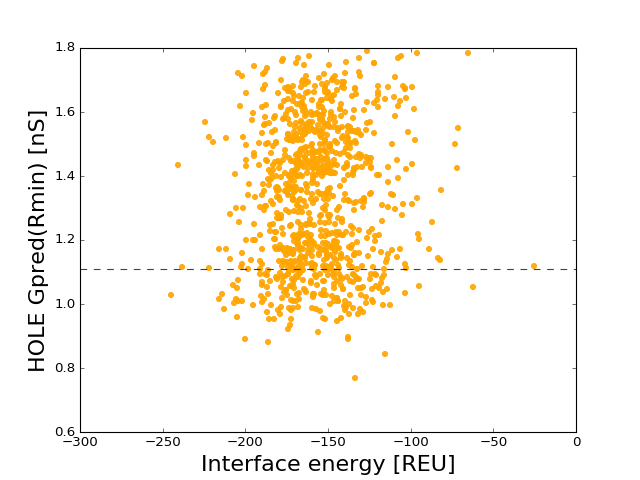

[]

In [26]:
fig_100 = plt.figure()
plt.xlim(-300,0)
plt.ylim(0.6,1.8)
plt.ylabel("HOLE Gpred(Rmin) [nS]", fontsize=20)
plt.xlabel("Interface energy [REU]", fontsize=20)
#plt.scatter(aa_rmsd_refined1[:-3], Gpred_Rmin_all, color='black', alpha=0.7)
plt.scatter(Isc_all, Gpred_Rmin_all, color='orange', alpha=0.9)
plt.plot((-300,0),(1.11,1.11),linestyle='--',color='black',alpha=0.75)

plt.plot()

In [27]:
len(Gpred_Rmin_all)

1000

<IPython.core.display.Javascript object>


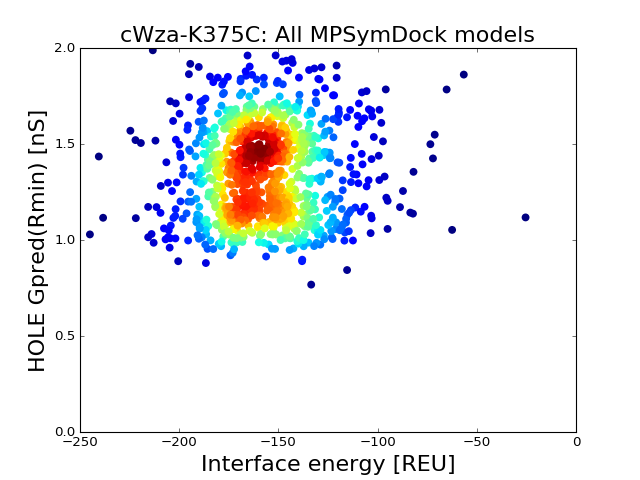

[]

In [28]:
from scipy.stats import gaussian_kde

x = Isc_all
y = Gpred_Rmin_all
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig = plt.figure()
plt.title("cWza-K375C: All MPSymDock models",fontsize=20)
plt.xlim(-250,0)
plt.ylim(0, 2)
plt.ylabel("HOLE Gpred(Rmin) [nS]", fontsize=20)
plt.xlabel("Interface energy [REU]", fontsize=20)
plt.scatter(x, y, c=z, s=50, edgecolor='')
#plt.plot((-300,0),(1.11,1.11),linestyle='--',color='black',alpha=0.75)

plt.plot()


# Contour plot Interface energy and Gpred

In [29]:
from scipy.stats import gaussian_kde

def density_estimation(m1,m2):
    xmin=min(m1)
    xmax=max(m1)
    ymin=min(m2)
    ymax=max(m2)
    X, Y = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X,Y,Z

In [30]:
def rm_none(data):
    return [x for x in data if x!='None']

In [32]:
#X = [Isc_all[i] for i in range(1000) if Gpred_Rmin_all[i]!='None']
X = Isc_all
Y = rm_none(Gpred_Rmin_all)
datacontour = list(density_estimation(X,Y))

In [33]:
XX,YY,ZZ = datacontour

<IPython.core.display.Javascript object>


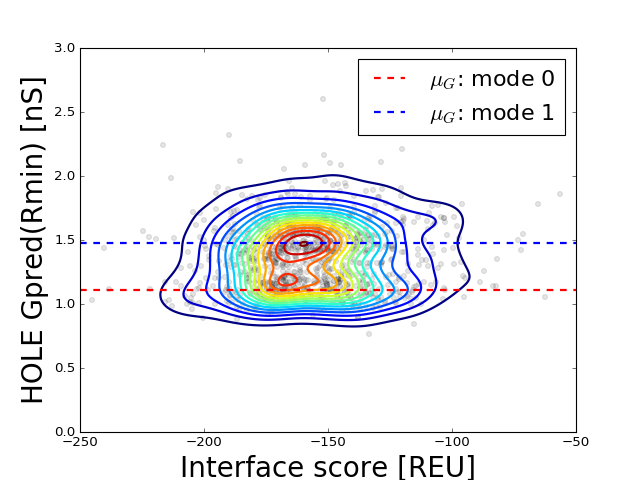

In [40]:

fig = plt.figure()
plt.scatter(X,Y,color='black',alpha=0.1)
plt.ylim(0,3)
plt.xlabel("Interface score [REU]",fontsize=25)
plt.xlim(-250,-50)
plt.ylabel("HOLE Gpred(Rmin) [nS]",fontsize=25)
plt.contour(XX,YY,ZZ,20,linewidths=2)

plt.plot((-250,50),(1.107,1.107),color='red',linestyle='--',lw=2,label='$\mu_G$: mode 0')
plt.plot((-250,50),(1.476,1.476),color='blue',linestyle='--',lw=2,label='$\mu_G$: mode 1')

#plt.title("cWza", fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Find out origin of biomodal distribution of conductances

Get minimum radii and plot

In [ ]:
VDWRmin_all = []
for id in model_ids:
    try:
        model_VDWRmin = session.query(HOLE_Output.HOLE_Rmin).filter_by(id = id).one()
        VDWRmin_all.append(model_VDWRmin[0])
    except:
        VDWRmin_all.append("None")


In [ ]:
hist_rmin = plt.figure()
plt.xlabel("HOLE Rmin ($\AA$)", fontsize=20)
plt.ylabel("Absolute frequency", fontsize=20)
plt.hist([v for v in VDWRmin_all if v != 'None'], bins=60, color='orange')
plt.show()

Analyse integrated aspect ratio 

In [ ]:
Gmacro_all = []
for id in model_ids:
    try:
        model_Gmacro = session.query(HOLE_Output.Gmacro).filter_by(id = id).one()
        Gmacro_all.append(model_Gmacro[0])
    except:
        Gmacro_all.append("None")

In [ ]:
hist_gmacro = plt.figure()

plt.xlabel("HOLE Gmacro ($\AA$)", fontsize=20)
plt.ylabel("Absolute frequency", fontsize=20)
plt.hist([v for v in Gmacro_all if v != 'None'], bins=50, color='orange')
plt.show()

In [ ]:
tseries_gmacro = plt.figure()

plt.xlabel("Model number", fontsize=20)
plt.ylabel("HOLE Gmacro [nS]", fontsize=20)
plt.plot([v for v in Gmacro_all if v != 'None'], color='orange', c = 'orange', linestyle='None', marker='o')
plt.show()

In [ ]:
len(Gpred_Rmin_all)

In [ ]:
fig_gmacro_groupsep = plt.figure()

#plt.xlim(0,1000)
#plt.ylim(1000,2500)

for n in Gpred_Rmin_Low_indeces:
    plt.scatter(n, Gpred_Rmin_all[n], color='yellow', alpha=1)
    
for n in Gpred_Rmin_High_indeces:
    plt.scatter(n, Gpred_Rmin_all[n], color='black', alpha=1)    

plt.show()



This gives us some idea about the quality of the fitting ...

# HOLE computed VDW Radii for all structures

In [19]:
infile = open('pdblist_refined1.txt', 'r')
pdbnames = [ l.rstrip() for l in infile.readlines()]

In [20]:
import re
HOLE_Z_VDWR = []
for pdb in pdbnames:
    hole_z = []
    hole_vdwr = []
    infile = open(pdb[:-3]+"hole_dat", "r")
    lines = infile.readlines()
    for l in lines:
        if re.search(r"mid-", l):
            a, b = l.split()[0:2]
            hole_z.append(float(a))
            hole_vdwr.append(float(b))
    HOLE_Z_VDWR.append([hole_z, hole_vdwr])            


<IPython.core.display.Javascript object>


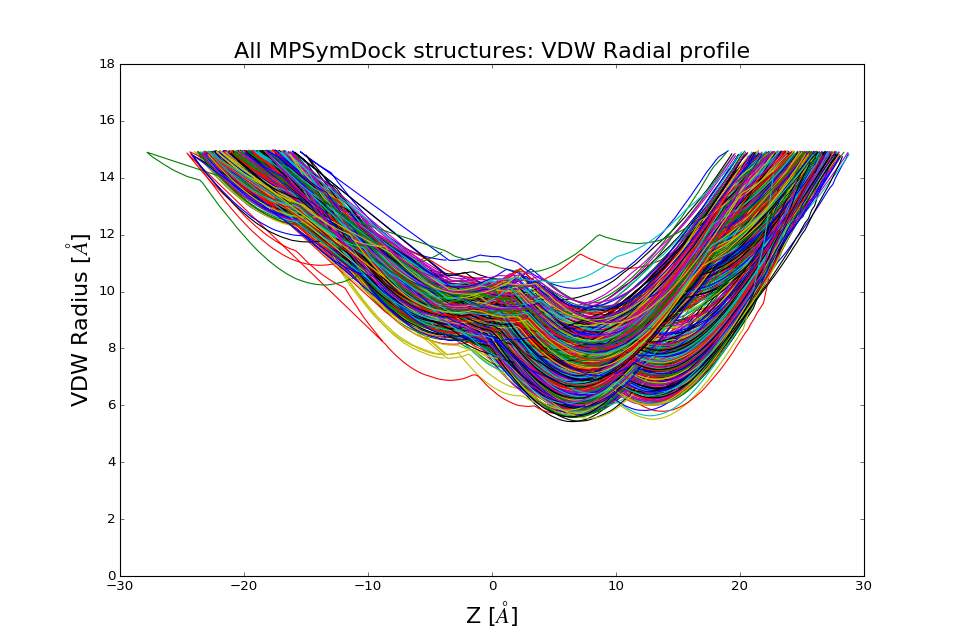

In [21]:
fig_vdwr_all = plt.figure(figsize=(12,8))

plt.ylim(0,18)
plt.xlabel("Z [$\AA$]", fontsize=20)
plt.ylabel("VDW Radius [$\AA$]", fontsize=20)
plt.title("All MPSymDock structures: VDW Radial profile", fontsize=20)

for n in range(1000):
    plt.plot(HOLE_Z_VDWR[n][0], HOLE_Z_VDWR[n][1])
    
#plt.axes().set_aspect('equal', 'datalim')
plt.show()

Separate VDW Radial profiles by **groups** classified in the **SH-paramter space**

In [ ]:
vdwr_group0 = np.asarray(HOLE_Z_VDWR)[np.asarray(labels) == 0]
vdwr_group1 = np.asarray(HOLE_Z_VDWR)[np.asarray(labels) == 1]
vdwr_group2 = np.asarray(HOLE_Z_VDWR)[np.asarray(labels) == 2]

In [ ]:
vdwr_groups_plot = plt.figure(figsize=(12,8))

plt.ylim(0,18)
plt.xlabel("Z [$\AA$]", fontsize=20)
plt.ylabel("VDW Radius [$\AA$]", fontsize=20)
plt.title("Group separation: VDW Radial profile", fontsize=20)


for n in range(len(vdwr_group0)):
    plt.plot(vdwr_group0[n][0], vdwr_group0[n][1], color='blue', alpha=0.2)

#for n in range(len(vdwr_group1)):
#    plt.plot(vdwr_group1[n][0], vdwr_group1[n][1], color='green', alpha=0.5)
    
for n in range(len(vdwr_group2)):
    plt.plot(vdwr_group2[n][0], vdwr_group2[n][1], color='red', alpha=0.9)

plt.show()

In [ ]:
vdwr_groups_plot = plt.figure(figsize=(12,8))

plt.ylim(0,18)
plt.xlabel("Z [$\AA$]", fontsize=20)
plt.ylabel("VDW Radius [$\AA$]", fontsize=20)
plt.title("Group separation: VDW Radial profile", fontsize=20)


#for n in range(len(vdwr_group0)):
#    plt.plot(vdwr_group0[n][0], vdwr_group0[n][1], color='blue', alpha=0.2)

for n in range(len(vdwr_group1)):
    plt.plot(vdwr_group1[n][0], vdwr_group1[n][1], color='green', alpha=0.5)
    
for n in range(len(vdwr_group2)):
    plt.plot(vdwr_group2[n][0], vdwr_group2[n][1], color='red', alpha=0.9)

plt.show()

Separate profiles discriminating between **Low and High conductance groups**

In [ ]:
Gpred_Rmin_High_indeces = []

for id in Gpred_Rmin_High_ids:
    name = session.query(Pdb.pdb_name).filter_by(id = id).one()
    Gpred_Rmin_High_indeces.append( int(name[0].split("_")[3])-1) 
    
Gpred_Rmin_Low_indeces = []

for id in Gpred_Rmin_Low_ids:
    name = session.query(Pdb.pdb_name).filter_by(id = id).one()
    Gpred_Rmin_Low_indeces.append( int(name[0].split("_")[3])-1) 


In [ ]:
print(len(Gpred_Rmin_High_indeces), len(Gpred_Rmin_Low_indeces))

In [ ]:
fig_vdwr_Gpred_Rmin_High = plt.figure(figsize=(12,8))

plt.ylim(0,18)
plt.xlabel("Z [$\AA$]", fontsize=20)
plt.ylabel("VDW Radius [$\AA$]", fontsize=20)
plt.title("High conductance group: VDW Radial profile", fontsize=20)


    
for n in Gpred_Rmin_Low_indeces:
    plt.plot(HOLE_Z_VDWR[n][0], HOLE_Z_VDWR[n][1], color='yellow', alpha=1)
    
for n in Gpred_Rmin_High_indeces:
    plt.plot(HOLE_Z_VDWR[n][0], HOLE_Z_VDWR[n][1], color='black', alpha=0.1)    
#plt.axes().set_aspect('equal', 'datalim')
plt.show()

Separate groups in **SH-parameters** space by **conductance group**


In [ ]:
# Define figure size and type
fig_shg = plt.figure(figsize=(10,8), dpi=80)
axsh = fig_shg.add_subplot(111,projection='3d')

# Customize plot appereance
axsh.set_title('Superhelical Paremeters: cWza*',fontsize=20)
axsh.set_xlabel("CA Radius p.r.c [$\AA$]",fontsize=15)
axsh.set_ylabel("Azimuthal angle p.r.c [deg]",fontsize=15)
axsh.set_zlabel("Helical axial position p.r.c [$\AA$]",fontsize=15)

# Plot all curves in superhelical-parameter space per structure 
for i in Gpred_Rmin_Low_indeces:
    x = np.array([v[1] for v in allmodels_rad[i]])
    y = np.array([v[1] for v in allmodels_azim[i]])
    z = np.array(allmodels_z[i])
    axsh.plot(x,y,z, color='yellow')

for i in Gpred_Rmin_High_indeces:
    x = np.array([v[1] for v in allmodels_rad[i]])
    y = np.array([v[1] for v in allmodels_azim[i]])
    z = np.array(allmodels_z[i])
    axsh.plot(x,y,z, color='black', alpha=0.1)


plt.show()

**Question**: What proportion of models from each conductance group make up each SH group?

In [ ]:
model_ids_group0 = np.asarray(model_ids)[np.asarray(labels) == 0]
model_ids_group1 = np.asarray(model_ids)[np.asarray(labels) == 1]
model_ids_group2 = np.asarray(model_ids)[np.asarray(labels) == 2]

In [ ]:
int0low = set(model_ids_group0).intersection(set(Gpred_Rmin_Low_ids))
int0high = set(model_ids_group0).intersection(set(Gpred_Rmin_High_ids))

print("Intersection SH-group 0 (blue) and Low/High conductance groups: ",\
      len(int0low),len(int0high), len(int0low)/len(int0high))

int1low = set(model_ids_group1).intersection(set(Gpred_Rmin_Low_ids))
int1high = set(model_ids_group1).intersection(set(Gpred_Rmin_High_ids))
print("Intersection SH-group 1 (green) and Low/High conductance groups: ",\
      len(int1low),len(int1high), len(int1low)/len(int1high))

int2low = set(model_ids_group2).intersection(set(Gpred_Rmin_Low_ids))
int2high = set(model_ids_group2).intersection(set(Gpred_Rmin_High_ids))
print("Intersection SH-group 2 (red) and Low/High conductance groups: ",\
      len(int2low),len(int2high), len(int2low)/len(int2high))

Differentiate between sidechain interface angles by conductance group

In [ ]:
# Define figure size and type
fig1 = plt.figure(figsize=(12,7))

# Customize plot appereance
plt.xlim(0,31)
plt.xlabel("Residue Number",fontsize=20)
plt.xticks(range(1,31),sequence,fontsize=15)
plt.ylim(-200,200)
plt.ylabel("Interface angle [deg]",fontsize=20)
plt.yticks(fontsize=15)

# Plot interface angle values per structure
for i in Gpred_Rmin_Low_indeces :
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.75,color='yellow' )
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')

for i in Gpred_Rmin_High_indeces :
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.5,color='black' )
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')
    
# Draw vertical dashed lines
for i in range(1,31):
    plt.plot((i,i),(-200,200),linestyle='--',color='black',alpha=0.75)


plt.show()

Filter out those models with conductance +/- sigma wrt mean from each mode

In [ ]:
# First mode
m1 = 0.932712
std1 = 0.097144

# Second mode
m2 = 1.267678
std2 = 0.076495



Gpred_Rmin_Low_stddist = []
Gpred_Rmin_High_stddist = []

Gpred_Rmin_Low_ids_stddist = []
Gpred_Rmin_High_ids_stddist = []

f=0.5

for id in model_ids:
    try:
        model_Gpred_Rmin = session.query(HOLE_Output.Gpred_Rmin).filter_by(id = id).one()
        G = model_Gpred_Rmin[0]
        if (G >= (m1 - f*std1)) and (G <= (m1 + f*std1)):
            Gpred_Rmin_Low_stddist.append(G)
            Gpred_Rmin_Low_ids_stddist.append(id)
        elif (G >= (m2 - f*std2)) and (G <= (m2 + f*std2)):
            Gpred_Rmin_High_stddist.append(G)
            Gpred_Rmin_High_ids_stddist.append(id)
    except:
        model_pdbname = session.query(Pdb).filter_by(id = id).one()
        print("No Conductance for model with id: ", id, model_pdbname.pdb_name)
        

In [ ]:
len(Gpred_Rmin_High_ids_stddist)

In [ ]:
fig_hist_stddist = plt.figure()
plt.hist(Gpred_Rmin_Low_stddist, bins = 10, color='black', alpha=0.75)
plt.hist(Gpred_Rmin_High_stddist, bins = 10, color='yellow', alpha=0.75)
plt.show()

In [ ]:
Gpred_Rmin_High_indeces_stddist = []

for id in Gpred_Rmin_High_ids_stddist:
    name = session.query(Pdb.pdb_name).filter_by(id = id).one()
    Gpred_Rmin_High_indeces_stddist.append( int(name[0].split("_")[3])-1) 
    
Gpred_Rmin_Low_indeces_stddist = []

for id in Gpred_Rmin_Low_ids_stddist:
    name = session.query(Pdb.pdb_name).filter_by(id = id).one()
    Gpred_Rmin_Low_indeces_stddist.append( int(name[0].split("_")[3])-1) 

In [ ]:
fig_vdwr_Gpred_Rmin_High_stddist = plt.figure(figsize=(12,8))

plt.ylim(0,18)
plt.xlabel("Z [$\AA$]", fontsize=20)
plt.ylabel("VDW Radius [$\AA$]", fontsize=20)
plt.title("High conductance group: VDW Radial profile", fontsize=20)


    
for n in Gpred_Rmin_Low_indeces_stddist:
    plt.plot(HOLE_Z_VDWR[n][0], HOLE_Z_VDWR[n][1], color='yellow', alpha=1)
    
for n in Gpred_Rmin_High_indeces_stddist:
    plt.plot(HOLE_Z_VDWR[n][0], HOLE_Z_VDWR[n][1], color='black', alpha=0.4)    
#plt.axes().set_aspect('equal', 'datalim')
plt.show()

In [ ]:
# Define figure size and type
fig_shg_stddist = plt.figure(figsize=(10,8), dpi=80)
axshstd = fig_shg_stddist.add_subplot(111,projection='3d')

# Customize plot appereance
axshstd.set_title('Superhelical Paremeters: cWza*',fontsize=20)
axshstd.set_xlabel("CA Radius p.r.c [$\AA$]",fontsize=15)
axshstd.set_ylabel("Azimuthal angle p.r.c [deg]",fontsize=15)
axshstd.set_zlabel("Helical axial position p.r.c [$\AA$]",fontsize=15)

# Plot all curves in superhelical-parameter space per structure 
for i in Gpred_Rmin_Low_indeces_stddist:
    x = np.array([v[1] for v in allmodels_rad[i]])
    y = np.array([v[1] for v in allmodels_azim[i]])
    z = np.array(allmodels_z[i])
    axshstd.plot(x,y,z, color='yellow')

for i in Gpred_Rmin_High_indeces_stddist:
    x = np.array([v[1] for v in allmodels_rad[i]])
    y = np.array([v[1] for v in allmodels_azim[i]])
    z = np.array(allmodels_z[i])
    axshstd.plot(x,y,z, color='black', alpha=0.5)


plt.show()

In [ ]:
# Define figure size and type
fig1_stddist = plt.figure(figsize=(12,7))

# Customize plot appereance
plt.xlim(0,31)
plt.xlabel("Residue Number",fontsize=20)
plt.xticks(range(1,31),sequence,fontsize=15)
plt.ylim(-200,200)
plt.ylabel("Interface angle [deg]",fontsize=20)
plt.yticks(fontsize=15)

# Plot interface angle values per structure
for i in Gpred_Rmin_Low_indeces_stddist :
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.75,color='yellow' )
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')

for i in Gpred_Rmin_High_indeces_stddist :
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.5,color='black' )
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')
    
# Draw vertical dashed lines
for i in range(1,31):
    plt.plot((i,i),(-200,200),linestyle='--',color='black',alpha=0.75)


plt.show()

Classify using machine learning algorithm over VDW Radii and Z data

In [ ]:
X_scia = []
for i in range(len(allmodels_iangles)):
    X_scia.append([v[1] for v in allmodels_iangles[0][:-1]])

In [ ]:
from sklearn.cluster import SpectralClustering
num_clusters = 4
model = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors',assign_labels='kmeans')
labels_scia = model.fit_predict(X_scia)

In [ ]:
labels_scia

In [ ]:
# Define figure size and type
fig_scia = plt.figure(figsize=(12,7))
cmap_scia = colors.ListedColormap(['blue', 'green', 'red', 'orange'])
# Customize plot appereance
plt.xlim(0,31)
plt.xlabel("Residue Number",fontsize=20)
plt.xticks(range(1,31),sequence,fontsize=15)
plt.ylim(-200,200)
plt.ylabel("Interface angle [deg]",fontsize=20)
plt.yticks(fontsize=15)

# Plot interface angle values per structure
for i in range(len(allmodels_iangles)):
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',color = cmap_scia(labels_scia[i]),alpha=0.5)
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')

# Draw vertical dashed lines
for i in range(1,31):
    plt.plot((i,i),(-200,200),linestyle='--',color='black',alpha=0.75)  

plt.show()

In [ ]:
# Define figure size and type
fig1_stddist = plt.figure(figsize=(12,7))

# Customize plot appereance
plt.xlim(0,31)
plt.xlabel("Residue Number",fontsize=20)
plt.xticks(range(1,31),sequence,fontsize=15)
plt.ylim(-200,200)
plt.ylabel("Interface angle [deg]",fontsize=20)
plt.yticks(fontsize=15)

# Plot interface angle values per structure
for i in Gpred_Rmin_Low_indeces :
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.75,color='yellow' )
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')

for i in Gpred_Rmin_High_indeceslist(n*np.ones(len(HOLE_Z_VDWR[n][0]))) :
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.5,color='black' )
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')
    
# Draw vertical dashed lines
for i in range(1,31):
    plt.plot((i,i),(-200,200),linestyle='--',color='black',alpha=0.75)


plt.show()

In [ ]:
len(lenxplusy)

In [ ]:
%matplotlib notebook
figtest0 = plt.show()

plt.xlabel("Model number")
plt.ylabel("VDW Rad profile, dataset length")

plt.plot(lenxplusy, color='magenta')
         
plt.show()

In [ ]:
print(np.array(lenxplusy).min(), np.array(lenxplusy).max())

In [ ]:
X_test_VDW = np.asarray(X_test_VDW,dtype=np.float32)

In [ ]:
from sklearn.cluster import SpectralClustering
num_clusters = 2
model = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors',assign_labels='kmeans')
labels = model.fit_predict(X_test_VDW)

In [ ]:
# Define discrete colour map for each classified group
from matplotlib import colors
cmap = colors.ListedColormap(['blue', 'green'])

fig_vdwr_Gpred_Rmin_High = plt.figure(figsize=(12,8))

plt.ylim(0,18)
plt.xlabel("Z [$\AA$]", fontsize=20)
plt.ylabel("VDW Radius [$\AA$]", fontsize=20)
plt.title("High conductance group: VDW Radial profile", fontsize=20)


    
for n in Gpred_Rmin_Low_indeces:
    plt.plot(HOLE_Z_VDWR[n][0], HOLE_Z_VDWR[n][1], color='yellow', alpha=1)
    
for n in Gpred_Rmin_High_indeces:
    plt.plot(HOLE_Z_VDWR[n][0], HOLE_Z_VDWR[n][1], color='black', alpha=0.1)    
#plt.axes().set_aspect('equal', 'datalim')
plt.show()


### Assessing metrics from VDW Radial profiles: mean, var, variability coeff

**Mean VDW Radii**

<IPython.core.display.Javascript object>


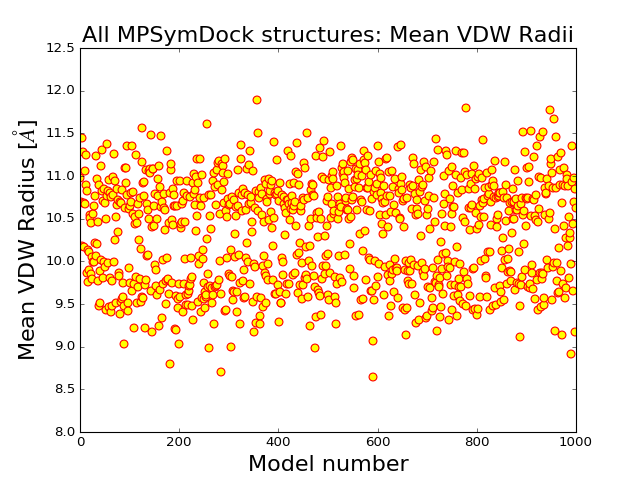

/home/ba13026/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [22]:
fig_vdwrmean_all = plt.figure()

plt.xlim(0,1000)

plt.xlabel("Model number", fontsize=20)
plt.ylabel("Mean VDW Radius [$\AA$]", fontsize=20)
plt.title("All MPSymDock structures: Mean VDW Radii", fontsize=20)

mean_HOLE_Z_VDWR = []
for n in range(1000):
    plt.scatter(n, np.mean(HOLE_Z_VDWR[n][1]), color='red', c='yellow', s=50, alpha=1)
    mean_HOLE_Z_VDWR.append(np.mean(HOLE_Z_VDWR[n][1]))
#plt.axes().set_aspect('equal', 'datalim')

plt.show()

<IPython.core.display.Javascript object>


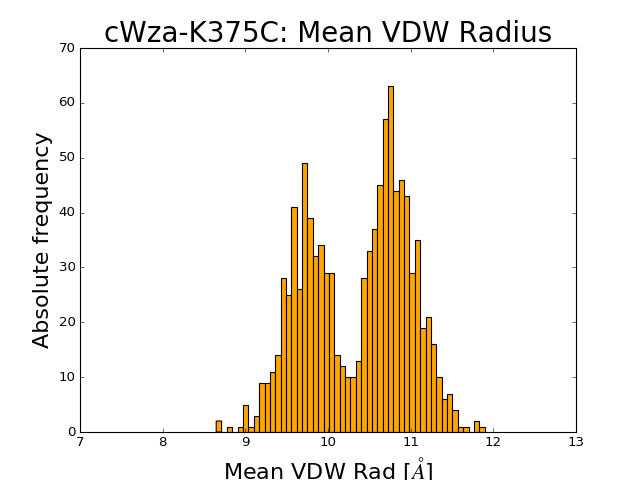

[]

In [23]:
hist_vdwrmean = plt.figure()
plt.xlim(7,13)
plt.ylim(0,70)
plt.title("cWza-K375C: Mean VDW Radius", fontsize=25)
plt.xlabel("Mean VDW Rad [$\AA$]", fontsize=20)
plt.ylabel("Absolute frequency", fontsize=20)
plt.hist([v for v in mean_HOLE_Z_VDWR if np.isnan(v) == False], bins = 50, color='orange', alpha=1)
plt.plot()

**Variance VDW Radii**

In [ ]:
fig_vdwrvar_all = plt.figure()

plt.xlim(0,1000)

plt.xlabel("Model number", fontsize=20)
plt.ylabel("Mean VDW Radius [$\AA$]", fontsize=20)
plt.title("All MPSymDock structures: Var VDW Radii", fontsize=20)

var_HOLE_Z_VDWR = []
for n in range(1000):
    plt.scatter(n, np.std(HOLE_Z_VDWR[n][1])**2, color='red', c='orange', s=50, alpha=1)
    var_HOLE_Z_VDWR.append(np.std(HOLE_Z_VDWR[n][1])**2)
#plt.axes().set_aspect('equal', 'datalim')

plt.show()

In [ ]:
hist_vdwrVar = plt.figure()
plt.xlim(0,12)
plt.ylim(0,120)
plt.title("cWza-K375C: All MPSymDock models", fontsize=25)
plt.xlabel("Var VDW Rad [$\AA$]", fontsize=20)
plt.ylabel("Absolute frequency", fontsize=20)
plt.hist([v for v in var_HOLE_Z_VDWR if np.isnan(v) == False], bins = 50, color='orange', alpha=1)
plt.plot()

**Coefficient of Variation VDW Radii**

In [ ]:
fig_vdwrvar_all = plt.figure()

plt.xlim(0,1000)

plt.xlabel("Model number", fontsize=20)
plt.ylabel("CV VDW Radius [$\AA$]", fontsize=20)
plt.title("All MPSymDock structures: CV VDW Radii", fontsize=20)

cv_HOLE_Z_VDWR = []
for n in range(1000):
    cv = np.std(HOLE_Z_VDWR[n][1])/np.mean(HOLE_Z_VDWR[n][1])
    plt.scatter(n, cv, color='red', c='orange', s=50, alpha=1)
    cv_HOLE_Z_VDWR.append(cv)
#plt.axes().set_aspect('equal', 'datalim')

plt.show()

In [ ]:
hist_vdwrVar = plt.figure()
plt.xlim(0.1, 0.6)
plt.ylim(0,100)
plt.title("cWza-K375C: All MPSymDock models", fontsize=25)
plt.xlabel("CV VDW Rad [$\AA$]", fontsize=20)
plt.ylabel("Absolute frequency", fontsize=20)
plt.hist([v for v in cv_HOLE_Z_VDWR if np.isnan(v) == False], bins = 50, color='orange', alpha=1)
plt.plot()

**Channel length**

In [75]:
len(HOLE_L)

1000

<IPython.core.display.Javascript object>


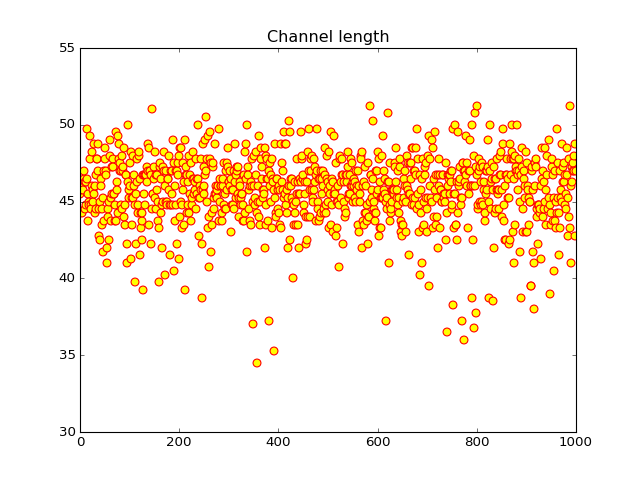

In [74]:
fig_L_all = plt.figure()

plt.xlim(0,1000)
plt.title("Channel length")
#plt.xlabel("Model number", fontsize=20)
#plt.ylabel("Mean VDW Radius [$\AA$]", fontsize=20)
#plt.title("All MPSymDock structures: Variation VDW Radii", fontsize=20)

HOLE_L = []
for n in range(1000):
    if len(HOLE_Z_VDWR[n][0]) != 0:
        dL = (np.asarray(HOLE_Z_VDWR[n][0])).max() - (np.asarray(HOLE_Z_VDWR[n][0])).min()
        HOLE_L.append(dL)
        plt.scatter(n, dL , color='red', c='yellow', s=50, alpha=1)
    else:
        HOLE_L.append(-1)
    
    #varcoeff_HOLE_Z_VDWR.append( np.std(HOLE_Z_VDWR[n][1]) / np.mean(HOLE_Z_VDWR[n][1]) )
    #plt.axes().set_aspect('equal', 'datalim')

plt.show()

<IPython.core.display.Javascript object>


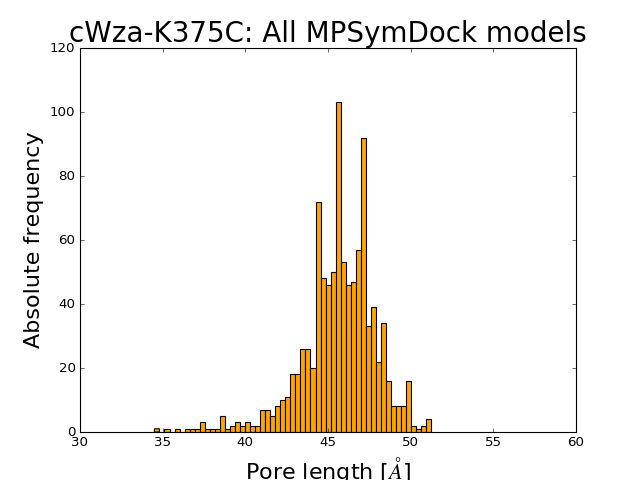

In [66]:
hist_L = plt.figure()
plt.xlim(30,60)
plt.ylim(0,120)
plt.title("cWza-K375C: All MPSymDock models", fontsize=25)
plt.xlabel("Pore length [$\AA$]", fontsize=20)
plt.ylabel("Absolute frequency", fontsize=20)
plt.hist(HOLE_L, bins = 55, color='orange')
plt.show()

## Identifying what AA's contribute to narrowing the channel more than others

In [69]:
Gmacro_all

NameError: name 'Gmacro_all' is not defined

In [ ]:
fig_rmin_gmacro = plt.figure()
plt.xlabel("HOLE Gmacro [nS]", fontsize=20)
plt.ylabel("VDW Rmin [$\AA$]", fontsize=20)
plt.scatter([v for v in Gmacro_all if v != 'None'], [v for v in VDWRmin_all if v != 'None'] )
plt.show()

In [68]:
from scipy.stats import gaussian_kde


# Calculate the point density
y = [v for v in Gmacro_all if v != 'None']
x = [v for v in VDWRmin_all if v != 'None']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.set_xlim(0,12)
ax.set_ylim(0,12)
ax.set_title("cWza-K375C: All MPSymDock models", fontsize=20)
ax.set_ylabel("HOLE Gpred(Rmin) [nS]", fontsize=20)
ax.set_xlabel("VDW Rmin [$\AA$]", fontsize=20)
ax.scatter(x, y, c=z, s=70, edgecolor='')
plt.show()

NameError: name 'Gmacro_all' is not defined

In [ ]:
Gmacro_all[-1]

<IPython.core.display.Javascript object>


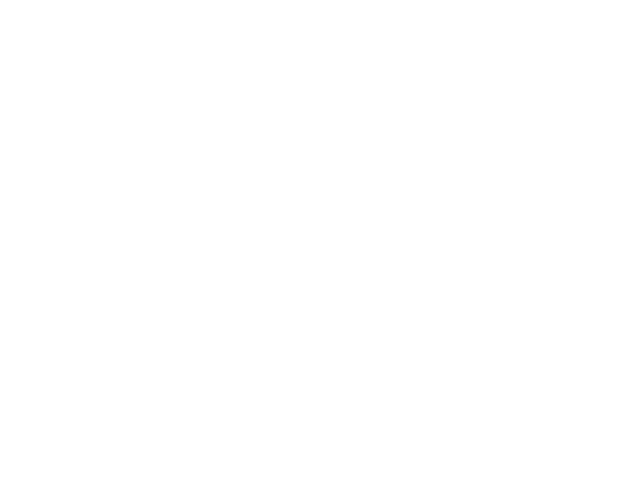

NameError: name 'Gmacro_all' is not defined

In [67]:
gmacro_l = plt.figure()
plt.scatter(HOLE_L, [v for v in Gmacro_all if v != 'None'], color = 'blue')
plt.plot()

In [ ]:
min(2,-2)

In [ ]:
from scipy.stats import gaussian_kde



# Calculate the point density
y = [w for w in mean_HOLE_Z_VDWR if np.isnan(w) == False]
x = HOLE_L
#xy = np.vstack([x,y])
#z = gaussian_kde(xy)(xy)
z = Gpred_Rmin_all

fig, ax = plt.subplots()
ax.set_title("cWza-K375C: All MPSymDock models", fontsize=20)
ax.set_ylabel("Mean VDW Rad [$\AA$]", fontsize=20)
ax.set_xlabel("Pore length [$\AA$]", fontsize=20)
ax.scatter(np.array(x), np.array(y), c=np.array(z),s=50, edgecolor='')#, norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0))
plt.show()


In [ ]:
x = []
y = []
N = min(len(Gpred_Rmin_all), len(HOLE_L))
for n in range(N):
    b = Gpred_Rmin_all[n]
    a = HOLE_L[n]
    if np.isnan(a) == False:
        x.append(a)
        y.append(b)


In [ ]:
from scipy.stats import gaussian_kde


# Calculate the point density
#x = HOLE_L
#y = [v for v in Gpred_Rmin_all if v != 'None']

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.set_ylim(0,2)
ax.set_xlim(30,60)
ax.set_title("cWza-K375C: All MPSymDock models", fontsize=20)
ax.set_xlabel("Pore length [$\AA$]", fontsize=20)
ax.set_ylabel("HOLE Gpred(Rmin) [nS]", fontsize=20)
ax.scatter(x, y, c=z, s=70, edgecolor='')
plt.show()


In [ ]:
x = HOLE_L
y = [v for v in Gmacro_all if v != 'None']
stats.pearsonr(x,y)

In [ ]:
len(mean_HOLE_Z_VDWR)

In [ ]:
gmacro_l = plt.figure()
plt.scatter([w for w in mean_HOLE_Z_VDWR if np.isnan(w) == False], [v for v in Gmacro_all if v != 'None'], color = 'blue')
plt.plot()

In [41]:
x = []
y = []
for n in range(1000):
    b = Gpred_Rmin_all[n]
    a = mean_HOLE_Z_VDWR[n]
    if np.isnan(a) == False:
        x.append(a)
        y.append(b)


<IPython.core.display.Javascript object>


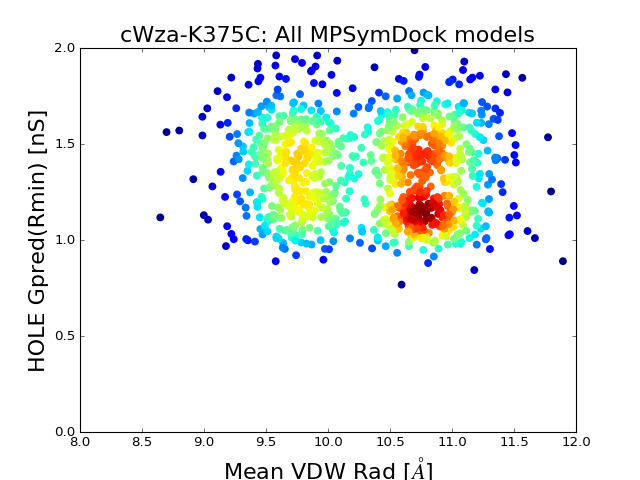

In [42]:


from scipy.stats import gaussian_kde


# Calculate the point density
#x = [w for w in mean_HOLE_Z_VDWR if np.isnan(w) == False]
#y = [v for v in Gmacro_all if v != 'None']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.set_ylim(0,2)
ax.set_xlim(8,12)
ax.set_title("cWza-K375C: All MPSymDock models", fontsize=20)
ax.set_xlabel("Mean VDW Rad [$\AA$]", fontsize=20)
ax.set_ylabel("HOLE Gpred(Rmin) [nS]", fontsize=20)
ax.scatter(x,y, c=z, s=50, edgecolor='')
plt.show()



Make contour plot

In [54]:
x = []
y = []
for n in range(1000):
    b = Gpred_Rmin_all[n]
    a = mean_HOLE_Z_VDWR[n]
    if np.isnan(a) == False:
        x.append(a)
        y.append(b)

In [55]:
datacontour2 = list(density_estimation(x,y))

In [56]:
XX1,YY1,ZZ1 = datacontour2

<IPython.core.display.Javascript object>


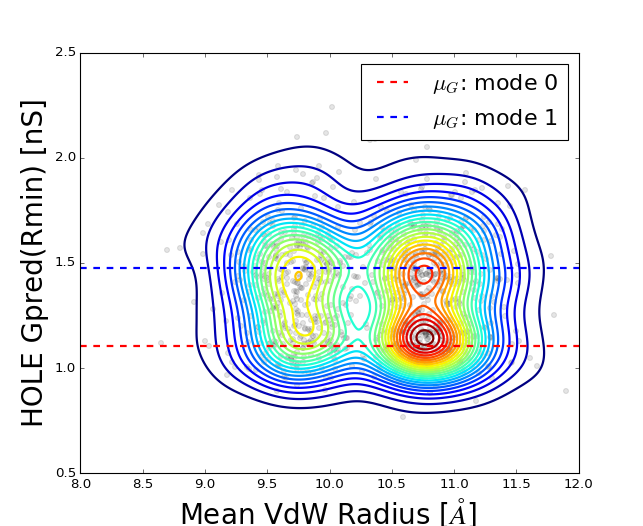

In [63]:
fig1 = plt.figure()
plt.scatter(x,y,color='black',alpha=0.1)
plt.ylim(0.5,2.5)
plt.xlabel("Mean VdW Radius [$\AA$] ",fontsize=25)
plt.xlim(8,12)
plt.ylabel("HOLE Gpred(Rmin) [nS]",fontsize=25)
plt.contour(XX1,YY1,ZZ1,25,linewidths=2)

plt.plot((8,12),(1.107,1.107),color='red',linestyle='--',lw=2,label='$\mu_G$: mode 0')
plt.plot((8,12),(1.476,1.476),color='blue',linestyle='--',lw=2,label='$\mu_G$: mode 1')

#plt.title("cWza", fontsize=20)
plt.legend(fontsize=20, loc=0)
plt.show()

Contour plot pore length vs. Gpred

In [71]:
len(HOLE_L)

995

In [76]:
x = []
y = []
for n in range(1000):
    b = Gpred_Rmin_all[n]
    a = HOLE_L[n]
    if np.isnan(a) == False:
        x.append(a)
        y.append(b)

In [78]:
len(y)

1000

In [79]:
#X = [Isc_all[i] for i in range(1000) if Gpred_Rmin_all[i]!='None']
#X2 = [w for w in HOLE_L if np.isnan(w) == False]
#Y2 = [v for v in Gpred_Rmin_all if v != 'None']
datacontour3 = list(density_estimation(x,y))

In [80]:
XX2,YY2,ZZ2 = datacontour3

<IPython.core.display.Javascript object>


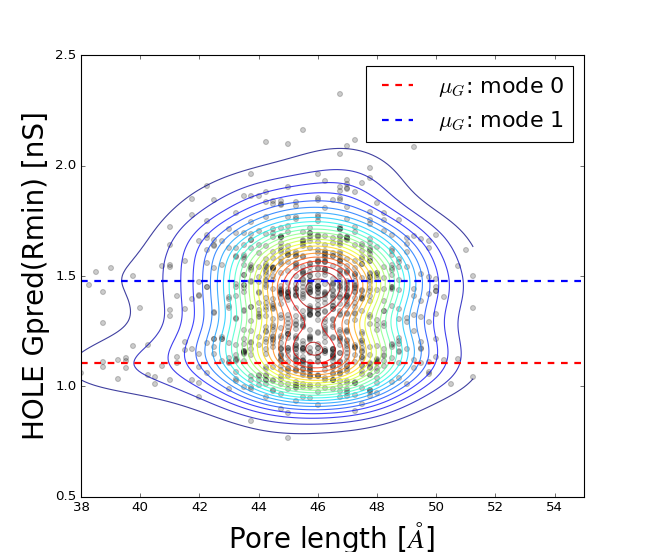

In [88]:
fig1 = plt.figure()
plt.scatter(x,y,color='black',alpha=0.2)
plt.ylim(0.5,2.5)
plt.xlabel("Pore length [$\AA$] ",fontsize=25)
plt.xlim(38,55)
plt.ylabel("HOLE Gpred(Rmin) [nS]",fontsize=25)
plt.contour(XX2,YY2,ZZ2,25,linewidths=1,alpha=0.75)

plt.plot((38,55),(1.107,1.107),color='red',linestyle='--',lw=2,label='$\mu_G$: mode 0')
plt.plot((38,55),(1.476,1.476),color='blue',linestyle='--',lw=2,label='$\mu_G$: mode 1')

#plt.title("cWza", fontsize=20)
plt.legend(fontsize=20, loc=0)
plt.show()

Scatter plot with Gmacro 

In [64]:


from scipy.stats import gaussian_kde


# Calculate the point density
x = [w for w in mean_HOLE_Z_VDWR if np.isnan(w) == False]
y = HOLE_L
xy = np.vstack([x,y])
#z = gaussian_kde(xy)(xy)
z = Gmacro_all

fig, ax = plt.subplots()
ax.set_title("All MPSymDock models", fontsize=20)
ax.set_xlabel("Mean VDW Rad [$\AA$]", fontsize=20)
ax.set_ylabel("HOLE Gmacro [nS]", fontsize=20)
ax.scatter(np.array(x), np.array(y))#, c=np.array(z))#, norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0))
plt.show()


NameError: name 'HOLE_L' is not defined

In [ ]:
from scipy import stats
stats.pearsonr([w for w in mean_HOLE_Z_VDWR if np.isnan(w) == False],[v for v in Gmacro_all if v != 'None'])

In [ ]:
x = []
y = []
for n in range(1000):
    b = Gpred_Rmin_all[n]
    a = var_HOLE_Z_VDWR[n]
    if np.isnan(a) == False:
        x.append(a)
        y.append(b)


In [ ]:


from scipy.stats import gaussian_kde


# Calculate the point density
#x = [v for v in var_HOLE_Z_VDWR if np.isnan(v) == False]
#y = [v for v in Gmacro_all if v != 'None']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.set_ylim(0,2)
ax.set_xlim(2,14)
ax.set_title("cWza-K375C: All MPSymDock models", fontsize=20)
ax.set_xlabel("Var VDW Rad [$\AA^2$]", fontsize=20)
ax.set_ylabel("HOLE Gpred(Rmin) [nS]", fontsize=20)
ax.scatter(x, y, c=z, s=50, edgecolor='')
plt.show()



In [ ]:
stats.pearsonr( [v for v in var_HOLE_Z_VDWR if np.isnan(v) == False], [v for v in Gmacro_all if v != 'None'])

In [ ]:
x = []
y = []
for n in range(1000):
    a = Gpred_Rmin_all[n]
    b = cv_HOLE_Z_VDWR[n]
    if np.isnan(b) == False:
        x.append(b)
        y.append(a)


In [ ]:


from scipy.stats import gaussian_kde


# Calculate the point density
#x = [v for v in cv_HOLE_Z_VDWR if np.isnan(v) == False]
#y = [v for v in Gpred_Rmin_all if v != 'None']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.set_title("cWza-K375C: All MPSymDock models", fontsize=20)
ax.set_xlabel("CV VDW Rad", fontsize=20)
ax.set_ylim(0,2)
ax.set_xlim(0.1,0.6)
ax.set_ylabel("HOLE Gpred(Rmin) [nS]", fontsize=20)
ax.scatter(x, y, c=z, s=50, edgecolor='')
plt.show()



In [ ]:
x = [v for v in cv_HOLE_Z_VDWR if np.isnan(v) == False]
y = [v for v in Gmacro_all if v != 'None']
stats.pearsonr(x,y)

## Assessing significance of group separation

Plot first curve from each classified group and show the error associated to each datapoint measurement as a 3D box centred at each point.

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

# Function to draw error cube
def error_cube(x, dx):
    points = np.array([[-1, -1, -1],
                  [1, -1, -1 ],
                  [1, 1, -1],
                  [-1, 1, -1],
                  [-1, -1, 1],
                  [1, -1, 1 ],
                  [1, 1, 1],
                  [-1, 1, 1]])

    P = [[dx[0],0,0],[0,dx[1],0],[0,0,dx[2]]]    
    Z = np.zeros((8,3))
    for i in range(8): Z[i,:] = np.dot(points[i,:],P)
    Z = Z + np.array(x)

    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')

    r = [-1,1]

    X, Y = np.meshgrid(r, r)
    # plot vertices
    #ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])

    # list of sides' polygons of figure
    verts = [[Z[0],Z[1],Z[2],Z[3]],
     [Z[4],Z[5],Z[6],Z[7]], 
     [Z[0],Z[1],Z[5],Z[4]], 
     [Z[2],Z[3],Z[7],Z[6]], 
     [Z[1],Z[2],Z[6],Z[5]],
     [Z[4],Z[7],Z[3],Z[0]], 
     [Z[2],Z[3],Z[7],Z[6]]]

    return verts
    # plot sides
    #ax.add_collection3d(Poly3DCollection(verts, 
     #facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

In [ ]:
fig3 = plt.figure(figsize=(10,8), dpi=80)

# Customize plot appereance
ax3 = fig3.add_subplot(111,projection='3d')
ax3.set_title('Superhelical Paremeters: cWza*',fontsize=20)
ax3.set_xlabel("CA Radius p.r.c [$\AA$]",fontsize=15)
ax3.set_ylabel("Azimuthal angle p.r.c [deg]",fontsize=15)
ax3.set_zlabel("Helical axial position p.r.c [$\AA$]",fontsize=15)

groups = 0
for i in [allpdbnames.index(model0), allpdbnames.index(model1),allpdbnames.index(model2) ]:
#for i in [allpdbnames.index(model1)]:
    x = [v[1] for v in allmodels_rad[i]]
    dx = [v[2] for v in allmodels_rad[i]]
    y = [v[1] for v in allmodels_azim[i]]
    dy = [v[2] for v in allmodels_azim[i]]
    z = allmodels_z[i]
    dz = 3*np.random.rand(len(x))
    for j in range(len(x)):
        verts = error_cube([x[j],y[j],z[j]], [dx[j],dy[j],dz[j]])
        ax3.add_collection3d(Poly3DCollection(verts,facecolors=cmap(groups),linewidths=1,edgecolors='black',alpha=.1))
    ax3.plot(x,y,z,linewidth=3)
    groups +=1

plt.show()

Is the following analysis valid despite difference in population groups? See F-test details.

1. Get first average curves from each group and with the combined data from both

In [ ]:
groupchoice = 2
group0_indexes = list(np.asarray(range(1000))[labels == groupchoice])

xmean0 = []
ymean0 = []
zmean0 = []

#print(group0_indexes)
from operator import itemgetter
#a = allmodels_rad
#b = group0_indexes
#c = itemgetter(*b)(a)

for res in range(32):
    #xmean0.append(np.mean( [v[res][1] for v in c] ))
    xmean0.append(np.mean( [v[res][1] for v in itemgetter(*group0_indexes)(allmodels_rad)] ))
    ymean0.append(np.mean( [v[res][1] for v in itemgetter(*group0_indexes)(allmodels_azim)]))
    #ymean0.append(np.mean( [v[res][1] for v in c] ))

zmean0 = np.mean(allmodels_z,axis=0)
    
print(xmean0, ymean0, zmean0)

In [ ]:
figN = plt.figure(figsize=(10,8), dpi=80)
axN = figN.add_subplot(111,projection='3d')
axN.set_title('Superhelical Paremeters: cWza*',fontsize=20)
axN.set_xlabel("CA Radius p.r.c [$\AA$]",fontsize=15)
axN.set_ylabel("Azimuthal angle p.r.c [deg]",fontsize=15)
axN.set_zlabel("Helical axial position p.r.c [$\AA$]",fontsize=15)
#groupchoice = 1
#groupchoice = 2
for i in list(np.asarray(range(0,1000))[labels == groupchoice]):
#for i in range(10):
    x = [v[1] for v in allmodels_rad[i]]
    y = [v[1] for v in allmodels_azim[i]]
    z = allmodels_z[i]
    axN.plot(x,y,z,color=cmap(groupchoice),alpha = 0.01)
axN.plot(xmean0,ymean0,zmean0,color=cmap(groupchoice),alpha=1,linewidth=2.5)
plt.show()

In [ ]:
allmodels_Gpred_Rmin = session.query(HOLE_Output.Gpred_Rmin).all()

In [ ]:
plt.hist(allmodels_Gpred_Rmin,bins=10)


In [ ]:
plt.show()